In [0]:
# Importing necessary python libraries:
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import load_files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D,Activation,Dropout,Flatten,Dense
from keras.regularizers import l2
from keras.layers.normalization import BatchNormalization
import os
import pandas as pd
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
from keras.preprocessing import image
import cv2
from sklearn.preprocessing import StandardScaler
from keras.optimizers import Adam
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import applications
import pickle
from os.path import isfile, isdir, getsize
import math 
from keras.utils.np_utils import to_categorical 
from keras.layers import Dense, GlobalAveragePooling2D
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools


In [0]:
# Unzip the training data set
from zipfile import ZipFile
file_name="training_set.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()

In [0]:
# Unzip the validation data set
file_name="valid_set.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()

In [0]:
# Unzip the test data set
file_name="test_set.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()

In [0]:
#Store the training and validation images in train_set and valid_set to reference in the below code.
train_set = '/content/training_set'
valid_set = '/content/valid_set'
test_set = '/content/test_set'

In [11]:
img_width, img_height = 224, 224
batch_size = 16
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    samplewise_center=False,
    featurewise_std_normalization=True,
    samplewise_std_normalization=False,
    rotation_range=90,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zca_whitening=True,
    horizontal_flip=True,
    vertical_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_set,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

valid_datagen = ImageDataGenerator(rescale=1. / 255)

validation_generator = valid_datagen.flow_from_directory(
    valid_set,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:339: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 960 images belonging to 6 classes.
Found 240 images belonging to 6 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:718: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


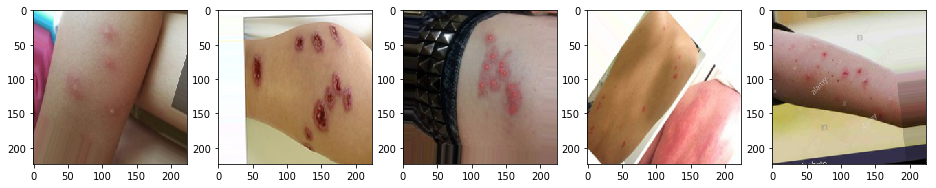

In [0]:
image = [next(train_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
l = [ax[i].imshow(image[i][0][0]) for i in range(0,5)]

In [0]:
## Code for using CyclicLR :

from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.0001, max_lr=0.0009, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [0]:
## code for using SGDR

from keras.callbacks import Callback
import keras.backend as K
import numpy as np

class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

In [0]:
## Code for using AdamW
from keras.optimizers import Optimizer
from keras import backend as K
import six
import copy
from six.moves import zip
from keras.utils.generic_utils import serialize_keras_object
from keras.utils.generic_utils import deserialize_keras_object
from keras.legacy import interfaces

class AdamW(Optimizer):
    """Adam optimizer.
    Default parameters follow those provided in the original paper.
    # Arguments
        lr: float >= 0. Learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        epsilon: float >= 0. Fuzz factor.
        decay: float >= 0. Learning rate decay over each update.
        weight_decay: float >= 0. Decoupled weight decay over each update.
    # References
        - [Adam - A Method for Stochastic Optimization](http://arxiv.org/abs/1412.6980v8)
        - [Optimization for Deep Learning Highlights in 2017](http://ruder.io/deep-learning-optimization-2017/index.html)
        - [Fixing Weight Decay Regularization in Adam](https://arxiv.org/abs/1711.05101)
    """

    def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999, weight_decay=1e-4,  # decoupled weight decay (1/6)
                 epsilon=1e-8, decay=0., **kwargs):
        super(AdamW, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.init_lr = lr # decoupled weight decay (2/6)
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
            self.wd = K.variable(weight_decay, name='weight_decay') # decoupled weight decay (3/6)
        self.epsilon = epsilon
        self.initial_decay = decay

    @interfaces.legacy_get_updates_support
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]
        wd = self.wd # decoupled weight decay (4/6)

        lr = self.lr
        if self.initial_decay > 0:
            lr *= (1. / (1. + self.decay * K.cast(self.iterations,
                                                  K.dtype(self.decay))))
        eta_t = lr / self.init_lr # decoupled weight decay (5/6)

        t = K.cast(self.iterations, K.floatx()) + 1
        lr_t = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) /
                     (1. - K.pow(self.beta_1, t)))

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        self.weights = [self.iterations] + ms + vs

        for p, g, m, v in zip(params, grads, ms, vs):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)
            p_t = p - lr_t * m_t / (K.sqrt(v_t) + self.epsilon) - eta_t * wd * p # decoupled weight decay (6/6)

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'decay': float(K.get_value(self.decay)),
                  'weight_decay': float(K.get_value(self.wd)),
                  'epsilon': self.epsilon}
        base_config = super(AdamW, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
## Code for using SGDW:
from keras.optimizers import Optimizer
from keras import backend as K
import six
import copy
from six.moves import zip
from keras.utils.generic_utils import serialize_keras_object
from keras.utils.generic_utils import deserialize_keras_object
from keras.legacy import interfaces

class SGDW(Optimizer):
    """Stochastic gradient descent optimizer.
    Includes support for momentum,
    learning rate decay, and Nesterov momentum.
    # Arguments
        lr: float >= 0. Learning rate.
        momentum: float >= 0. Parameter updates momentum.
        decay: float >= 0. Learning rate decay over each update.
        nesterov: boolean. Whether to apply Nesterov momentum.
        weight_decay: float >= 0. Decoupled weight decay over each update.
    # References
        - [Optimization for Deep Learning Highlights in 2017](http://ruder.io/deep-learning-optimization-2017/index.html)
        - [Fixing Weight Decay Regularization in Adam](https://arxiv.org/abs/1711.05101)
    """

    def __init__(self, lr=0.01, momentum=0., decay=0., weight_decay=1e-4, # decoupled weight decay (1/6)
                 nesterov=False, **kwargs):
        super(SGDW, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.init_lr = lr # decoupled weight decay (2/6)
            self.momentum = K.variable(momentum, name='momentum')
            self.decay = K.variable(decay, name='decay')
            self.wd = K.variable(weight_decay, name='weight_decay') # decoupled weight decay (3/6)
        self.initial_decay = decay
        self.nesterov = nesterov

    @interfaces.legacy_get_updates_support
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]
        wd = self.wd  # decoupled weight decay (4/6)

        lr = self.lr
        if self.initial_decay > 0:
            lr *= (1. / (1. + self.decay * K.cast(self.iterations,
                                                  K.dtype(self.decay))))
        eta_t = lr / self.init_lr # decoupled weight decay (5/6)
        
        # momentum
        shapes = [K.int_shape(p) for p in params]
        moments = [K.zeros(shape) for shape in shapes]
        self.weights = [self.iterations] + moments
        for p, g, m in zip(params, grads, moments):
            v = self.momentum * m - lr * g  # velocity
            self.updates.append(K.update(m, v))

            if self.nesterov:
                new_p = p + self.momentum * v - lr * g  - eta_t * wd * p  # decoupled weight decay (6/6)
            else:
                new_p = p + v - lr * wd * p # decoupled weight decay

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'momentum': float(K.get_value(self.momentum)),
                  'decay': float(K.get_value(self.decay)),
                  'nesterov': self.nesterov}
        base_config = super(SGDW, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

### Bottle neck features

In [17]:
model_vgg19 = applications.VGG19(include_top=False, input_shape=(img_width, img_height, 3),weights='imagenet')
model_vgg19.summary()

Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_____

In [18]:
num_train_samples = len(train_generator.filenames)  
num_classes = len(train_generator.class_indices)
batch_size = 16
print (num_train_samples)
print (num_classes)
   
predict_train_size = int(math.ceil(num_train_samples / batch_size))  
print (predict_train_size)

960
6
60


In [19]:
bottleneck_features_train_vgg19_WA = model_vgg19.predict_generator(train_generator, predict_train_size)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:718: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [0]:
np.save('bottleneck_features_train_vgg19_wa.npy', bottleneck_features_train_vgg19_WA)

In [21]:
bottleneck_features_train_vgg19_WA.shape

(960, 7, 7, 512)

In [22]:
num_valid_samples = len(validation_generator.filenames)  
num_valid_classes = len(validation_generator.class_indices)
batch_size = 16
print (num_valid_samples)
print (num_valid_classes)
   
predict_valid_size = int(math.ceil(num_valid_samples / batch_size))  
print (predict_valid_size)

240
6
15


In [0]:
bottleneck_features_valid_vgg19_WA = model_vgg19.predict_generator(validation_generator, predict_valid_size)

In [0]:
np.save('bottleneck_features_valid_vgg19_wa.npy', bottleneck_features_valid_vgg19_WA)

In [25]:
bottleneck_features_valid_vgg19_WA.shape

(240, 7, 7, 512)

In [0]:
# load the bottleneck features saved earlier 
train_data = np.load('bottleneck_features_train_vgg19_wa.npy')  

In [0]:
# load the bottleneck features saved earlier 
valid_data = np.load('bottleneck_features_valid_vgg19_wa.npy')  

In [28]:
x=train_data.shape[1:]
print (x)

(7, 7, 512)


In [29]:
model_bn = Sequential()  
model_bn.add(Flatten(input_shape=train_data.shape[1:]))
model_bn.add(Dense(512, activation='relu',kernel_initializer='he_normal')) 
model_bn.add(BatchNormalization(axis=-1))
model_bn.add(Dropout(0.2))  
model_bn.add(Dense(num_classes, activation='softmax'))  
model_bn.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               12845568  
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 3078      
Total params: 12,850,694
Trainable params: 12,849,670
Non-trainable params: 1,024
_________________________________________________________________


### Model 1:


In [0]:
# Model 1 , training block5_conv3,block5_pool and sequential_1 layers and freezing other top layers.

In [0]:
vgg19 = applications.VGG19(include_top=False, weights='imagenet', input_shape=(img_width, img_height, 3))

In [0]:
Model_vgg19_WA1 = Model(inputs= vgg19.input, outputs= model_bn(vgg19.output))

In [0]:
layers = [(layer, layer.name, layer.trainable) for layer in Model_vgg19_WA1.layers]
pd.DataFrame(layers, columns=['Layer', 'Layer Name', 'Layer Train']) 

,Layer,Layer Name,Layer Train
0,<keras.engine.input_layer.InputLayer object at...,input_26,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,True
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,True
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,True
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,True
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,True
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,True
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,True
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,True
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,True


In [0]:
for layer in Model_vgg19_WA1.layers[:-1]:
    layer.trainable = False

In [0]:
layers = [(layer, layer.name, layer.trainable) for layer in Model_vgg19_WA1.layers]
pd.DataFrame(layers, columns=['Layer ', 'Layer Name', 'Layer Train']) 

,Layer,Layer Name,Layer Train
0,<keras.engine.input_layer.InputLayer object at...,input_26,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,False


In [0]:
Model_vgg19_WA1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
from keras.optimizers import *
earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
best_model_vgg19_wa1 = ModelCheckpoint('best_model_vgg19_wa1.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
#optimizer = optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#optimizer = optimizers.Adam()
#optimizer = optimizers.RMSprop()
optimizer = optimizers.SGD()
#optimizer = SGDW(lr=0.0001, momentum=0., decay=0., weight_decay=1e-4, nesterov=False)
#optimizer = AdamW(lr=0.0001, beta_1=0.9, beta_2=0.999, weight_decay=1e-4, epsilon=1e-8, decay=0.)
clr = CyclicLR(mode='triangular2')
#sgdr = SGDRScheduler(min_lr=0.0001, max_lr = 0.0009, 
#                     steps_per_epoch = np.ceil(train_generator.n/batch_size),
#                     lr_decay = 0.9,
#                     cycle_length=10, 
#                     mult_factor = 2)

#optimizer = tf.contrib.opt.AdamWOptimizer(weight_decay=0.0)
Model_vgg19_WA1.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
#learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
#                                            patience=20, 
#                                            verbose=1, 
#                                            factor=0.5, 
#                                            min_lr=0.0001)


In [0]:
img_width, img_height = 224, 224
batch_size = 16
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    samplewise_center=False,
    featurewise_std_normalization=True,
    samplewise_std_normalization=False,
    rotation_range=90,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zca_whitening=True,
    horizontal_flip=True,
    vertical_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_set,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

valid_datagen = ImageDataGenerator(rescale=1. / 255)

validation_generator = valid_datagen.flow_from_directory(
    valid_set,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:339: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 960 images belonging to 6 classes.
Found 240 images belonging to 6 classes.


In [0]:
Model1_VGG19_WA1=Model_vgg19_WA1.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n//batch_size,
    epochs=300,
    validation_data=validation_generator,
    validation_steps=validation_generator.n//batch_size,
    callbacks = [earlystop,best_model_vgg19_wa1,clr]) 

Epoch 1/300


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:718: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 3/60 [>.............................] - ETA: 1:05 - loss: 2.3488 - acc: 0.2708

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.501169). Check your callbacks.
  % delta_t_median)


60/60 [==============================] - 21s 356ms/step - loss: 2.2697 - acc: 0.2000 - val_loss: 2.2678 - val_acc: 0.1792

Epoch 00001: val_acc improved from -inf to 0.17917, saving model to best_model_vgg19_wa1.h5
Epoch 2/300
60/60 [==============================] - 17s 285ms/step - loss: 2.0508 - acc: 0.2292 - val_loss: 2.1589 - val_acc: 0.2333

Epoch 00002: val_acc improved from 0.17917 to 0.23333, saving model to best_model_vgg19_wa1.h5
Epoch 3/300
60/60 [==============================] - 18s 293ms/step - loss: 1.9908 - acc: 0.2365 - val_loss: 2.0723 - val_acc: 0.2167

Epoch 00003: val_acc did not improve from 0.23333
Epoch 4/300
60/60 [==============================] - 18s 292ms/step - loss: 1.9596 - acc: 0.2406 - val_loss: 2.2056 - val_acc: 0.1958

Epoch 00004: val_acc did not improve from 0.23333
Epoch 5/300
60/60 [==============================] - 17s 290ms/step - loss: 1.9343 - acc: 0.2615 - val_loss: 2.0211 - val_acc: 0.2250

Epoch 00005: val_acc did not improve from 0.23333


In [0]:
saved_model_baseModel_Vgg19_WA1 = load_model('best_model_vgg19_wa1.h5')

In [0]:
loss, accuracy = saved_model_baseModel_Vgg19_WA1.evaluate_generator(train_generator,train_generator.n//batch_size)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Loss: {:.4f}".format(loss))
loss, accuracy = saved_model_baseModel_Vgg19_WA1.evaluate_generator(validation_generator,validation_generator.n//batch_size)
print("Validation Accuracy:  {:.4f}".format(accuracy))
print("Validation Loss:  {:.4f}".format(loss))

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:718: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Training Accuracy: 0.5792
Training Loss: 1.1302
Validation Accuracy:  0.5667
Validation Loss:  1.2955


In [0]:
batch_size = 1
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory=test_set,
    target_size=(img_height, img_width),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

test_generator.reset()

Found 240 images belonging to 6 classes.


In [0]:
pred=saved_model_baseModel_Vgg19_WA1.predict_generator(test_generator,verbose=1,steps=test_generator.samples/batch_size)

240/240 [==============================] - 10s 43ms/step


In [0]:
predicted_class_indices=np.argmax(pred,axis=1)

In [0]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

predict_class_Label = lambda l :[0 if predictions=='BedbugBites' else 1 if predictions=='FleaBites' else 2 if predictions == 'MosquitoBites' else 3 if predictions == 'SandflyBites' else 4 if predictions == 'SpiderBites' else 5 for predictions in l]
pred_class_label = predict_class_Label(predictions)

In [0]:
filenames=test_generator.filenames
class_labels = list(test_generator.class_indices.keys()) 
true_classes = test_generator.classes
results=pd.DataFrame({"Filename":filenames,
                      "True Class":true_classes,
                      "Predict Class":pred_class_label,
                      "Predictions":predictions})
results.head(5)

,Filename,Predict Class,Predictions,True Class
0,BedbugBites/000023 resized resize224.jpg,0,BedbugBites,0
1,BedbugBites/000038 resized resize224.jpg,0,BedbugBites,0
2,BedbugBites/000041 resized resize224.jpg,4,SpiderBites,0
3,BedbugBites/000042 resized resize224.jpg,0,BedbugBites,0
4,BedbugBites/000045 resized resize224.jpg,0,BedbugBites,0


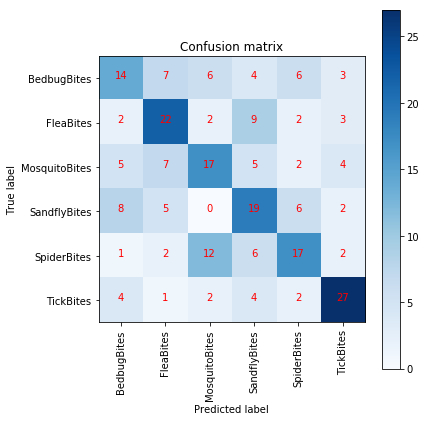

In [0]:
def metrics_confusion_matrix(cmtx, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    fig = plt.figure(figsize=(6,6))
    plt.imshow(cmtx, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cmtx = cmtx.astype('float') / cmtx.sum(axis=1)[:, np.newaxis]
       
    for i, j in itertools.product(range(cmtx.shape[0]), range(cmtx.shape[1])):
        plt.text(j, i, cmtx[i, j],
                 horizontalalignment="center",
                 color="red" )

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# confusion matrix
confusionMatrix = confusion_matrix(true_classes, pred_class_label) 

# plot the confusion matrix
metrics_confusion_matrix(confusionMatrix, classes = class_labels) 

In [0]:
class_labels = list(test_generator.class_indices.keys())   
report = metrics.classification_report(true_classes, pred_class_label, target_names=class_labels)
print(report) 

               precision    recall  f1-score   support

  BedbugBites       0.41      0.35      0.38        40
    FleaBites       0.50      0.55      0.52        40
MosquitoBites       0.44      0.42      0.43        40
 SandflyBites       0.40      0.47      0.44        40
  SpiderBites       0.49      0.42      0.45        40
    TickBites       0.66      0.68      0.67        40

    micro avg       0.48      0.48      0.48       240
    macro avg       0.48      0.48      0.48       240
 weighted avg       0.48      0.48      0.48       240



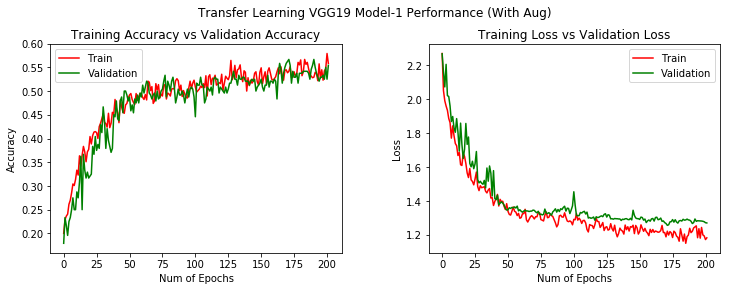

In [0]:
# summarize history for accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = fig.suptitle('Transfer Learning VGG19 Model-1 Performance (With Aug)', fontsize=12)
fig.subplots_adjust(top=0.85, wspace=0.3)

#plt.figure(0)
ax1.plot(Model1_VGG19_WA1.history['acc'],'r')
ax1.plot(Model1_VGG19_WA1.history['val_acc'],'g')
ax1.set_xlabel("Num of Epochs")
ax1.set_ylabel("Accuracy")
ax1.set_title("Training Accuracy vs Validation Accuracy")
ax1.legend(['Train','Validation'])

#ax2.figure(1)
ax2.plot(Model1_VGG19_WA1.history['loss'],'r')
ax2.plot(Model1_VGG19_WA1.history['val_loss'],'g')
ax2.set_xlabel("Num of Epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Training Loss vs Validation Loss")
ax2.legend(['Train','Validation'])

**Model 2:**

In [0]:
# Model 2 , training block5_conv3,block5_pool and sequential_1 layers and freezing other top layers.

In [0]:
vgg19 = applications.VGG19(include_top=False, weights='imagenet', input_shape=(img_width, img_height, 3))

In [0]:
Model_vgg19_WA2 = Model(inputs= vgg19.input, outputs= model_bn(vgg19.output))

In [0]:
layers = [(layer, layer.name, layer.trainable) for layer in Model_vgg19_WA2.layers]
pd.DataFrame(layers, columns=['Layer', 'Layer Name', 'Layer Train']) 

,Layer,Layer Name,Layer Train
0,<keras.engine.input_layer.InputLayer object at...,input_27,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,True
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,True
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,True
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,True
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,True
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,True
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,True
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,True
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,True


In [0]:
for layer in Model_vgg19_WA2.layers[:-3]:
    layer.trainable = False

In [0]:
layers = [(layer, layer.name, layer.trainable) for layer in Model_vgg19_WA2.layers]
pd.DataFrame(layers, columns=['Layer ', 'Layer Name', 'Layer Train']) 

,Layer,Layer Name,Layer Train
0,<keras.engine.input_layer.InputLayer object at...,input_27,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,False


In [0]:
Model_vgg19_WA2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
from keras.optimizers import *
earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
best_model_vgg19_wa2 = ModelCheckpoint('best_model_vgg19_wa2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
#optimizer = optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#optimizer = optimizers.Adam()
#optimizer = optimizers.RMSprop()
optimizer = optimizers.SGD()
#optimizer = SGDW(lr=0.0001, momentum=0., decay=0., weight_decay=1e-4, nesterov=False)
#optimizer = AdamW(lr=0.0001, beta_1=0.9, beta_2=0.999, weight_decay=1e-4, epsilon=1e-8, decay=0.)
clr = CyclicLR(mode='triangular2')
#sgdr = SGDRScheduler(min_lr=0.0001, max_lr = 0.0009, 
#                     steps_per_epoch = np.ceil(train_generator.n/batch_size),
#                     lr_decay = 0.9,
#                     cycle_length=10, 
#                     mult_factor = 2)

#optimizer = tf.contrib.opt.AdamWOptimizer(weight_decay=0.0)
Model_vgg19_WA2.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
#learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
#                                            patience=20, 
#                                            verbose=1, 
#                                            factor=0.5, 
#                                            min_lr=0.0001)


In [0]:
img_width, img_height = 224, 224
batch_size = 16
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    samplewise_center=False,
    featurewise_std_normalization=True,
    samplewise_std_normalization=False,
    rotation_range=90,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zca_whitening=True,
    horizontal_flip=True,
    vertical_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_set,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

valid_datagen = ImageDataGenerator(rescale=1. / 255)

validation_generator = valid_datagen.flow_from_directory(
    valid_set,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:339: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 960 images belonging to 6 classes.
Found 240 images belonging to 6 classes.


In [0]:
Model1_VGG19_WA2=Model_vgg19_WA2.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n//batch_size,
    epochs=300,
    validation_data=validation_generator,
    validation_steps=validation_generator.n//batch_size,
    callbacks = [earlystop,best_model_vgg19_wa2,clr]) 

Epoch 1/300


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:718: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 2/60 [>.............................] - ETA: 1:37 - loss: 1.1629 - acc: 0.5312

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.535030). Check your callbacks.
  % delta_t_median)


60/60 [==============================] - 22s 359ms/step - loss: 1.1732 - acc: 0.5438 - val_loss: 1.2729 - val_acc: 0.5292

Epoch 00001: val_acc improved from -inf to 0.52917, saving model to best_model_vgg19_wa2.h5
Epoch 2/300
60/60 [==============================] - 17s 288ms/step - loss: 1.2104 - acc: 0.5312 - val_loss: 1.2794 - val_acc: 0.5292

Epoch 00002: val_acc did not improve from 0.52917
Epoch 3/300
60/60 [==============================] - 18s 292ms/step - loss: 1.1949 - acc: 0.5323 - val_loss: 1.2869 - val_acc: 0.5417

Epoch 00003: val_acc improved from 0.52917 to 0.54167, saving model to best_model_vgg19_wa2.h5
Epoch 4/300
60/60 [==============================] - 17s 288ms/step - loss: 1.2168 - acc: 0.5427 - val_loss: 1.2667 - val_acc: 0.5333

Epoch 00004: val_acc did not improve from 0.54167
Epoch 5/300
60/60 [==============================] - 17s 288ms/step - loss: 1.2027 - acc: 0.5396 - val_loss: 1.2665 - val_acc: 0.5500

Epoch 00005: val_acc improved from 0.54167 to 0.55

In [0]:
saved_model_baseModel_Vgg19_WA2 = load_model('best_model_vgg19_wa2.h5')

In [0]:
loss, accuracy = saved_model_baseModel_Vgg19_WA2.evaluate_generator(train_generator,train_generator.n//batch_size)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Loss: {:.4f}".format(loss))
loss, accuracy = saved_model_baseModel_Vgg19_WA2.evaluate_generator(validation_generator,validation_generator.n//batch_size)
print("Validation Accuracy:  {:.4f}".format(accuracy))
print("Validation Loss:  {:.4f}".format(loss))

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:718: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Training Accuracy: 0.7167
Training Loss: 0.8155
Validation Accuracy:  0.6917
Validation Loss:  1.0538


In [0]:
batch_size = 1
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory=test_set,
    target_size=(img_height, img_width),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

test_generator.reset()

Found 240 images belonging to 6 classes.


In [0]:
pred=saved_model_baseModel_Vgg19_WA2.predict_generator(test_generator,verbose=1,steps=test_generator.samples/batch_size)

240/240 [==============================] - 8s 33ms/step


In [0]:
predicted_class_indices=np.argmax(pred,axis=1)

In [0]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

predict_class_Label = lambda l :[0 if predictions=='BedbugBites' else 1 if predictions=='FleaBites' else 2 if predictions == 'MosquitoBites' else 3 if predictions == 'SandflyBites' else 4 if predictions == 'SpiderBites' else 5 for predictions in l]
pred_class_label = predict_class_Label(predictions)

In [0]:
filenames=test_generator.filenames
class_labels = list(test_generator.class_indices.keys()) 
true_classes = test_generator.classes
results=pd.DataFrame({"Filename":filenames,
                      "True Class":true_classes,
                      "Predict Class":pred_class_label,
                      "Predictions":predictions})
results.head(5)

,Filename,Predict Class,Predictions,True Class
0,BedbugBites/000023 resized resize224.jpg,0,BedbugBites,0
1,BedbugBites/000038 resized resize224.jpg,0,BedbugBites,0
2,BedbugBites/000041 resized resize224.jpg,4,SpiderBites,0
3,BedbugBites/000042 resized resize224.jpg,0,BedbugBites,0
4,BedbugBites/000045 resized resize224.jpg,0,BedbugBites,0


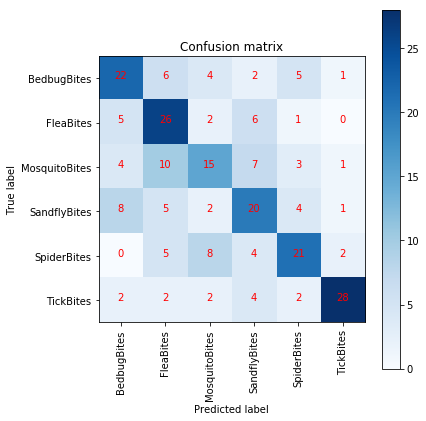

In [0]:
def metrics_confusion_matrix(cmtx, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    fig = plt.figure(figsize=(6,6))
    plt.imshow(cmtx, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cmtx = cmtx.astype('float') / cmtx.sum(axis=1)[:, np.newaxis]
       
    for i, j in itertools.product(range(cmtx.shape[0]), range(cmtx.shape[1])):
        plt.text(j, i, cmtx[i, j],
                 horizontalalignment="center",
                 color="red" )

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# confusion matrix
confusionMatrix = confusion_matrix(true_classes, pred_class_label) 

# plot the confusion matrix
metrics_confusion_matrix(confusionMatrix, classes = class_labels) 

In [0]:
class_labels = list(test_generator.class_indices.keys())   
report = metrics.classification_report(true_classes, pred_class_label, target_names=class_labels)
print(report) 

               precision    recall  f1-score   support

  BedbugBites       0.54      0.55      0.54        40
    FleaBites       0.48      0.65      0.55        40
MosquitoBites       0.45      0.38      0.41        40
 SandflyBites       0.47      0.50      0.48        40
  SpiderBites       0.58      0.53      0.55        40
    TickBites       0.85      0.70      0.77        40

    micro avg       0.55      0.55      0.55       240
    macro avg       0.56      0.55      0.55       240
 weighted avg       0.56      0.55      0.55       240



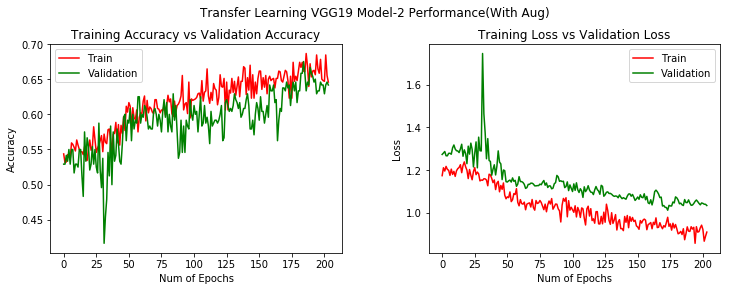

In [0]:
# summarize history for accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = fig.suptitle('Transfer Learning VGG19 Model-2 Performance(With Aug)', fontsize=12)
fig.subplots_adjust(top=0.85, wspace=0.3)

#plt.figure(0)
ax1.plot(Model1_VGG19_WA2.history['acc'],'r')
ax1.plot(Model1_VGG19_WA2.history['val_acc'],'g')
ax1.set_xlabel("Num of Epochs")
ax1.set_ylabel("Accuracy")
ax1.set_title("Training Accuracy vs Validation Accuracy")
ax1.legend(['Train','Validation'])

#ax2.figure(1)
ax2.plot(Model1_VGG19_WA2.history['loss'],'r')
ax2.plot(Model1_VGG19_WA2.history['val_loss'],'g')
ax2.set_xlabel("Num of Epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Training Loss vs Validation Loss")
ax2.legend(['Train','Validation'])

**Model 3:**

In [0]:
# Model 3 , training block5_conv1,block5_conv2,block5_conv3,block5_pool and sequential_1 layers and freezing other top layers.

In [0]:
vgg19 = applications.VGG19(include_top=False, weights='imagenet', input_shape=(img_width, img_height, 3))

In [0]:
Model_vgg19_WA3 = Model(inputs= vgg19.input, outputs= model_bn(vgg19.output))

In [0]:
layers = [(layer, layer.name, layer.trainable) for layer in Model_vgg19_WA3.layers]
pd.DataFrame(layers, columns=['Layer', 'Layer Name', 'Layer Train']) 

,Layer,Layer Name,Layer Train
0,<keras.engine.input_layer.InputLayer object at...,input_29,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,True
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,True
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,True
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,True
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,True
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,True
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,True
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,True
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,True


In [0]:
for layer in Model_vgg19_WA3.layers[:-6]:
    layer.trainable = False

In [0]:
layers = [(layer, layer.name, layer.trainable) for layer in Model_vgg19_WA3.layers]
pd.DataFrame(layers, columns=['Layer', 'Layer Name', 'Layer Train']) 

,Layer,Layer Name,Layer Train
0,<keras.engine.input_layer.InputLayer object at...,input_29,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,False


In [0]:
Model_vgg19_WA3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
from keras.optimizers import *
earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
best_model_vgg19_wa3 = ModelCheckpoint('best_model_vgg19_wa3.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
#optimizer = optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#optimizer = optimizers.Adam()
#optimizer = optimizers.RMSprop()
optimizer = optimizers.SGD()
#optimizer = SGDW(lr=0.0001, momentum=0., decay=0., weight_decay=1e-4, nesterov=False)
#optimizer = AdamW(lr=0.0001, beta_1=0.9, beta_2=0.999, weight_decay=1e-4, epsilon=1e-8, decay=0.)
clr = CyclicLR(mode='triangular2')
#sgdr = SGDRScheduler(min_lr=0.0001, max_lr = 0.0009, 
#                     steps_per_epoch = np.ceil(train_generator.n/batch_size),
#                     lr_decay = 0.9,
#                     cycle_length=10, 
#                     mult_factor = 2)

#optimizer = tf.contrib.opt.AdamWOptimizer(weight_decay=0.0)
Model_vgg19_WA3.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
#learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
#                                            patience=20, 
#                                            verbose=1, 
#                                            factor=0.5, 
#                                            min_lr=0.0001)


In [0]:
img_width, img_height = 224, 224
batch_size = 16
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    samplewise_center=False,
    featurewise_std_normalization=True,
    samplewise_std_normalization=False,
    rotation_range=90,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zca_whitening=True,
    horizontal_flip=True,
    vertical_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_set,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

valid_datagen = ImageDataGenerator(rescale=1. / 255)

validation_generator = valid_datagen.flow_from_directory(
    valid_set,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:339: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 960 images belonging to 6 classes.
Found 240 images belonging to 6 classes.


In [0]:
Model1_VGG19_WA3=Model_vgg19_WA3.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n//batch_size,
    epochs=300,
    validation_data=validation_generator,
    validation_steps=validation_generator.n//batch_size,
    callbacks = [earlystop,best_model_vgg19_wa3,clr]) 

Epoch 1/300


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:718: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 2/60 [>.............................] - ETA: 1:46 - loss: 1.0495 - acc: 0.5312

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.576487). Check your callbacks.
  % delta_t_median)


60/60 [==============================] - 23s 377ms/step - loss: 1.1250 - acc: 0.5823 - val_loss: 1.1978 - val_acc: 0.5792

Epoch 00001: val_acc improved from -inf to 0.57917, saving model to best_model_vgg19_wa3.h5
Epoch 2/300
60/60 [==============================] - 18s 301ms/step - loss: 1.1612 - acc: 0.5656 - val_loss: 1.2319 - val_acc: 0.5292

Epoch 00002: val_acc did not improve from 0.57917
Epoch 3/300
60/60 [==============================] - 18s 308ms/step - loss: 1.1202 - acc: 0.5792 - val_loss: 1.1775 - val_acc: 0.5667

Epoch 00003: val_acc did not improve from 0.57917
Epoch 4/300
60/60 [==============================] - 19s 309ms/step - loss: 1.0953 - acc: 0.5802 - val_loss: 1.1774 - val_acc: 0.5750

Epoch 00004: val_acc did not improve from 0.57917
Epoch 5/300
60/60 [==============================] - 18s 307ms/step - loss: 1.1296 - acc: 0.5615 - val_loss: 1.2905 - val_acc: 0.5000

Epoch 00005: val_acc did not improve from 0.57917
Epoch 6/300
60/60 [==========================

In [0]:
saved_model_baseModel_Vgg19_WA3 = load_model('best_model_vgg19_wa3.h5')

In [0]:
loss, accuracy = saved_model_baseModel_Vgg19_WA3.evaluate_generator(train_generator,train_generator.n//batch_size)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Loss: {:.4f}".format(loss))
loss, accuracy = saved_model_baseModel_Vgg19_WA3.evaluate_generator(validation_generator,validation_generator.n//batch_size)
print("Validation Accuracy:  {:.4f}".format(accuracy))
print("Validation Loss:  {:.4f}".format(loss))

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:718: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Training Accuracy: 0.7979
Training Loss: 0.5400
Validation Accuracy:  0.7625
Validation Loss:  0.7711


In [0]:
batch_size = 1
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory=test_set,
    target_size=(img_height, img_width),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

test_generator.reset()

Found 240 images belonging to 6 classes.


In [0]:
pred=saved_model_baseModel_Vgg19_WA3.predict_generator(test_generator,verbose=1,steps=test_generator.samples/batch_size)

240/240 [==============================] - 12s 49ms/step


In [0]:
predicted_class_indices=np.argmax(pred,axis=1)

In [0]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

predict_class_Label = lambda l :[0 if predictions=='BedbugBites' else 1 if predictions=='FleaBites' else 2 if predictions == 'MosquitoBites' else 3 if predictions == 'SandflyBites' else 4 if predictions == 'SpiderBites' else 5 for predictions in l]
pred_class_label = predict_class_Label(predictions)

In [0]:
filenames=test_generator.filenames
class_labels = list(test_generator.class_indices.keys()) 
true_classes = test_generator.classes
results=pd.DataFrame({"Filename":filenames,
                      "True Class":true_classes,
                      "Predict Class":pred_class_label,
                      "Predictions":predictions})
results.head(5)

,Filename,Predict Class,Predictions,True Class
0,BedbugBites/000023 resized resize224.jpg,0,BedbugBites,0
1,BedbugBites/000038 resized resize224.jpg,0,BedbugBites,0
2,BedbugBites/000041 resized resize224.jpg,4,SpiderBites,0
3,BedbugBites/000042 resized resize224.jpg,0,BedbugBites,0
4,BedbugBites/000045 resized resize224.jpg,0,BedbugBites,0


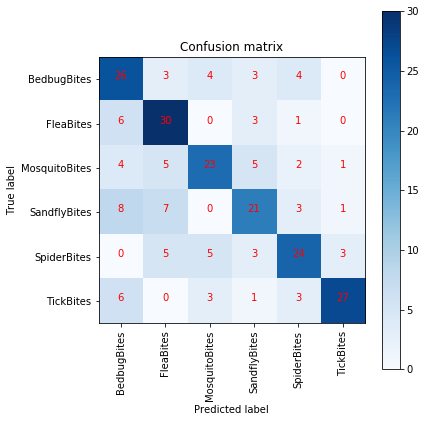

In [0]:
def metrics_confusion_matrix(cmtx, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    fig = plt.figure(figsize=(6,6))
    plt.imshow(cmtx, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cmtx = cmtx.astype('float') / cmtx.sum(axis=1)[:, np.newaxis]
       
    for i, j in itertools.product(range(cmtx.shape[0]), range(cmtx.shape[1])):
        plt.text(j, i, cmtx[i, j],
                 horizontalalignment="center",
                 color="red" )

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# confusion matrix
confusionMatrix = confusion_matrix(true_classes, pred_class_label) 

# plot the confusion matrix
metrics_confusion_matrix(confusionMatrix, classes = class_labels) 

In [0]:
class_labels = list(test_generator.class_indices.keys())   
report = metrics.classification_report(true_classes, pred_class_label, target_names=class_labels)
print(report) 

               precision    recall  f1-score   support

  BedbugBites       0.52      0.65      0.58        40
    FleaBites       0.60      0.75      0.67        40
MosquitoBites       0.66      0.57      0.61        40
 SandflyBites       0.58      0.53      0.55        40
  SpiderBites       0.65      0.60      0.62        40
    TickBites       0.84      0.68      0.75        40

    micro avg       0.63      0.63      0.63       240
    macro avg       0.64      0.63      0.63       240
 weighted avg       0.64      0.63      0.63       240



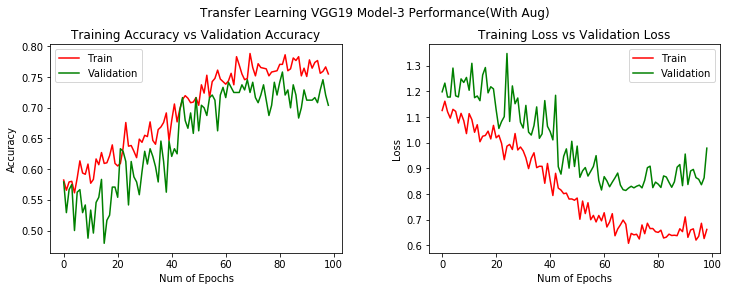

In [0]:
# summarize history for accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = fig.suptitle('Transfer Learning VGG19 Model-3 Performance(With Aug)', fontsize=12)
fig.subplots_adjust(top=0.85, wspace=0.3)

#plt.figure(0)
ax1.plot(Model1_VGG19_WA3.history['acc'],'r')
ax1.plot(Model1_VGG19_WA3.history['val_acc'],'g')
ax1.set_xlabel("Num of Epochs")
ax1.set_ylabel("Accuracy")
ax1.set_title("Training Accuracy vs Validation Accuracy")
ax1.legend(['Train','Validation'])

#ax2.figure(1)
ax2.plot(Model1_VGG19_WA3.history['loss'],'r')
ax2.plot(Model1_VGG19_WA3.history['val_loss'],'g')
ax2.set_xlabel("Num of Epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Training Loss vs Validation Loss")
ax2.legend(['Train','Validation'])

**Model 4:**

In [0]:
# Model 4 block4_conv3,block4_conv2,block4_pool,training block5_conv1,block5_conv2,block5_conv3,block5_pool and sequential_1 layers 
#and freezing other top layers.

In [0]:
vgg19 = applications.VGG19(include_top=False, weights='imagenet', input_shape=(img_width, img_height, 3))

In [0]:
Model_vgg19_WA4 = Model(inputs= vgg19.input, outputs= model_bn(vgg19.output))

In [32]:
layers = [(layer, layer.name, layer.trainable) for layer in Model_vgg19_WA4.layers]
pd.DataFrame(layers, columns=['Layer ', 'Layer Name', 'Layer Train']) 

,Layer,Layer Name,Layer Train
0,<keras.engine.input_layer.InputLayer object at...,input_2,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,True
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,True
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,True
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,True
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,True
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,True
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,True
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,True
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,True


In [0]:
for layer in Model_vgg19_WA4.layers[:-8]:
    layer.trainable = False

In [34]:
layers = [(layer, layer.name, layer.trainable) for layer in Model_vgg19_WA4.layers]
pd.DataFrame(layers, columns=['Layer ', 'Layer Name', 'Layer Train']) 

,Layer,Layer Name,Layer Train
0,<keras.engine.input_layer.InputLayer object at...,input_2,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,False


In [35]:
Model_vgg19_WA4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
from keras.optimizers import *
earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
best_model_vgg19_wa4 = ModelCheckpoint('best_model_vgg19_wa4.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
#optimizer = optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#optimizer = optimizers.Adam()
#optimizer = optimizers.RMSprop()
optimizer = optimizers.SGD()
#optimizer = SGDW(lr=0.0001, momentum=0., decay=0., weight_decay=1e-4, nesterov=False)
#optimizer = AdamW(lr=0.0001, beta_1=0.9, beta_2=0.999, weight_decay=1e-4, epsilon=1e-8, decay=0.)
clr = CyclicLR(mode='triangular2')
#sgdr = SGDRScheduler(min_lr=0.0001, max_lr = 0.0009, 
#                     steps_per_epoch = np.ceil(train_generator.n/batch_size),
#                     lr_decay = 0.9,
#                     cycle_length=10, 
#                     mult_factor = 2)

#optimizer = tf.contrib.opt.AdamWOptimizer(weight_decay=0.0)
Model_vgg19_WA4.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
#learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
#                                            patience=20, 
#                                            verbose=1, 
#                                            factor=0.5, 
#                                            min_lr=0.0001)

In [37]:
img_width, img_height = 224, 224
batch_size = 16
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    samplewise_center=False,
    featurewise_std_normalization=True,
    samplewise_std_normalization=False,
    rotation_range=90,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zca_whitening=True,
    horizontal_flip=True,
    vertical_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_set,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

valid_datagen = ImageDataGenerator(rescale=1. / 255)

validation_generator = valid_datagen.flow_from_directory(
    valid_set,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:339: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 960 images belonging to 6 classes.
Found 240 images belonging to 6 classes.


In [38]:
Model1_VGG19_WA4=Model_vgg19_WA4.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n//batch_size,
    epochs=300,
    validation_data=validation_generator,
    validation_steps=validation_generator.n//batch_size,
    callbacks = [earlystop,best_model_vgg19_wa4,clr]) 

Instructions for updating:
Use tf.cast instead.
Epoch 1/300


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:718: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


60/60 [==============================] - 21s 352ms/step - loss: 2.1579 - acc: 0.2260 - val_loss: 2.1322 - val_acc: 0.2417

Epoch 00001: val_acc improved from -inf to 0.24167, saving model to best_model_vgg19_wa4.h5
Epoch 2/300
60/60 [==============================] - 18s 306ms/step - loss: 2.0524 - acc: 0.2323 - val_loss: 2.0950 - val_acc: 0.2333

Epoch 00002: val_acc did not improve from 0.24167
Epoch 3/300
60/60 [==============================] - 19s 312ms/step - loss: 1.9598 - acc: 0.2594 - val_loss: 1.9795 - val_acc: 0.2667

Epoch 00003: val_acc improved from 0.24167 to 0.26667, saving model to best_model_vgg19_wa4.h5
Epoch 4/300
60/60 [==============================] - 19s 310ms/step - loss: 1.8812 - acc: 0.2792 - val_loss: 1.9267 - val_acc: 0.3125

Epoch 00004: val_acc improved from 0.26667 to 0.31250, saving model to best_model_vgg19_wa4.h5
Epoch 5/300
60/60 [==============================] - 19s 310ms/step - loss: 1.8436 - acc: 0.3156 - val_loss: 1.9575 - val_acc: 0.2958

Epoch

In [0]:
saved_model_baseModel_Vgg19_WA4 = load_model('best_model_vgg19_wa4.h5')

In [41]:
loss, accuracy = saved_model_baseModel_Vgg19_WA4.evaluate_generator(train_generator,train_generator.n//batch_size)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Loss: {:.4f}".format(loss))
loss, accuracy = saved_model_baseModel_Vgg19_WA4.evaluate_generator(validation_generator,validation_generator.n//batch_size)
print("Validation Accuracy:  {:.4f}".format(accuracy))
print("Validation Loss:  {:.4f}".format(loss))

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:718: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Training Accuracy: 0.7792
Training Loss: 0.6520
Validation Accuracy:  0.7250
Validation Loss:  0.8800


In [42]:
batch_size = 1
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory=test_set,
    target_size=(img_height, img_width),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

test_generator.reset()

Found 240 images belonging to 6 classes.


In [43]:
pred=saved_model_baseModel_Vgg19_WA4.predict_generator(test_generator,verbose=1,steps=test_generator.samples/batch_size)

240/240 [==============================] - 9s 36ms/step


In [0]:
predicted_class_indices=np.argmax(pred,axis=1)

In [0]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

predict_class_Label = lambda l :[0 if predictions=='BedbugBites' else 1 if predictions=='FleaBites' else 2 if predictions == 'MosquitoBites' else 3 if predictions == 'SandflyBites' else 4 if predictions == 'SpiderBites' else 5 for predictions in l]
pred_class_label = predict_class_Label(predictions)

In [46]:
filenames=test_generator.filenames
class_labels = list(test_generator.class_indices.keys()) 
true_classes = test_generator.classes
results=pd.DataFrame({"Filename":filenames,
                      "True Class":true_classes,
                      "Predict Class":pred_class_label,
                      "Predictions":predictions})
results.head(5)

,Filename,Predict Class,Predictions,True Class
0,BedbugBites/000023 resized resize224.jpg,0,BedbugBites,0
1,BedbugBites/000038 resized resize224.jpg,0,BedbugBites,0
2,BedbugBites/000041 resized resize224.jpg,4,SpiderBites,0
3,BedbugBites/000042 resized resize224.jpg,0,BedbugBites,0
4,BedbugBites/000045 resized resize224.jpg,0,BedbugBites,0


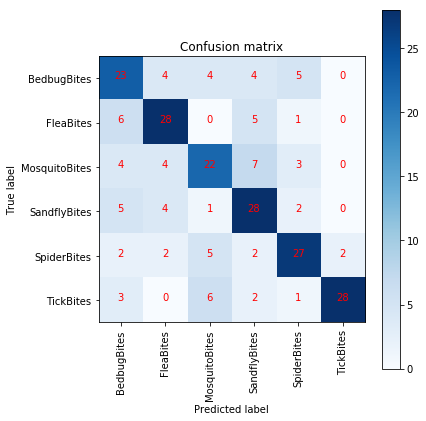

In [47]:
def metrics_confusion_matrix(cmtx, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    fig = plt.figure(figsize=(6,6))
    plt.imshow(cmtx, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cmtx = cmtx.astype('float') / cmtx.sum(axis=1)[:, np.newaxis]
       
    for i, j in itertools.product(range(cmtx.shape[0]), range(cmtx.shape[1])):
        plt.text(j, i, cmtx[i, j],
                 horizontalalignment="center",
                 color="red" )

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# confusion matrix
confusionMatrix = confusion_matrix(true_classes, pred_class_label) 

# plot the confusion matrix
metrics_confusion_matrix(confusionMatrix, classes = class_labels) 

In [48]:
class_labels = list(test_generator.class_indices.keys())   
report = metrics.classification_report(true_classes, pred_class_label, target_names=class_labels)
print(report) 

               precision    recall  f1-score   support

  BedbugBites       0.53      0.57      0.55        40
    FleaBites       0.67      0.70      0.68        40
MosquitoBites       0.58      0.55      0.56        40
 SandflyBites       0.58      0.70      0.64        40
  SpiderBites       0.69      0.68      0.68        40
    TickBites       0.93      0.70      0.80        40

    micro avg       0.65      0.65      0.65       240
    macro avg       0.66      0.65      0.65       240
 weighted avg       0.66      0.65      0.65       240



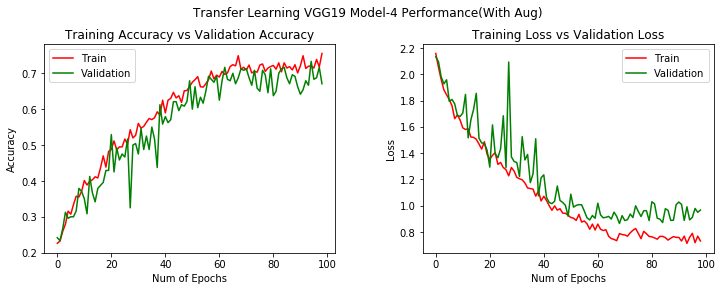

In [49]:
# summarize history for accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = fig.suptitle('Transfer Learning VGG19 Model-4 Performance(With Aug)', fontsize=12)
fig.subplots_adjust(top=0.85, wspace=0.3)

#plt.figure(0)
ax1.plot(Model1_VGG19_WA4.history['acc'],'r')
ax1.plot(Model1_VGG19_WA4.history['val_acc'],'g')
ax1.set_xlabel("Num of Epochs")
ax1.set_ylabel("Accuracy")
ax1.set_title("Training Accuracy vs Validation Accuracy")
ax1.legend(['Train','Validation'])

#ax2.figure(1)
ax2.plot(Model1_VGG19_WA4.history['loss'],'r')
ax2.plot(Model1_VGG19_WA4.history['val_loss'],'g')
ax2.set_xlabel("Num of Epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Training Loss vs Validation Loss")
ax2.legend(['Train','Validation'])

**Model 5:**

In [0]:
# Model 5 block4_conv1,block4_conv2,block4_conv3,block4_pool,training block5_conv1,block5_conv2,block5_conv3,block5_pool and sequential_1 layers 
#and freezing other top layers.

In [0]:
vgg19 = applications.VGG19(include_top=False, weights='imagenet', input_shape=(img_width, img_height, 3))

In [0]:
Model_vgg19_WA5 = Model(inputs= vgg19.input, outputs= model_bn(vgg19.output))

In [53]:
layers = [(layer, layer.name, layer.trainable) for layer in Model_vgg19_WA5.layers]
pd.DataFrame(layers, columns=['Layer', 'Layer Name', 'Layer Train']) 

,Layer,Layer Name,Layer Train
0,<keras.engine.input_layer.InputLayer object at...,input_3,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,True
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,True
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,True
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,True
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,True
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,True
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,True
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,True
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,True


In [0]:
for layer in Model_vgg19_WA5.layers[:-9]:
    layer.trainable = False

In [55]:
layers = [(layer, layer.name, layer.trainable) for layer in Model_vgg19_WA5.layers]
pd.DataFrame(layers, columns=['Layer', 'Layer Name', 'Layer Train']) 

,Layer,Layer Name,Layer Train
0,<keras.engine.input_layer.InputLayer object at...,input_3,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,False


In [56]:
Model_vgg19_WA5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
from keras.optimizers import *
earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
best_model_vgg19_wa5 = ModelCheckpoint('best_model_vgg19_wa5.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
#optimizer = optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#optimizer = optimizers.Adam()
#optimizer = optimizers.RMSprop()
optimizer = optimizers.SGD()
#optimizer = SGDW(lr=0.0001, momentum=0., decay=0., weight_decay=1e-4, nesterov=False)
#optimizer = AdamW(lr=0.0001, beta_1=0.9, beta_2=0.999, weight_decay=1e-4, epsilon=1e-8, decay=0.)
clr = CyclicLR(mode='triangular2')
#sgdr = SGDRScheduler(min_lr=0.0001, max_lr = 0.0009, 
#                     steps_per_epoch = np.ceil(train_generator.n/batch_size),
#                     lr_decay = 0.9,
#                     cycle_length=10, 
#                     mult_factor = 2)

#optimizer = tf.contrib.opt.AdamWOptimizer(weight_decay=0.0)
Model_vgg19_WA5.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
#learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
#                                            patience=20, 
#                                            verbose=1, 
#                                            factor=0.5, 
#                                            min_lr=0.0001)

In [58]:
img_width, img_height = 224, 224
batch_size = 16
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    samplewise_center=False,
    featurewise_std_normalization=True,
    samplewise_std_normalization=False,
    rotation_range=90,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zca_whitening=True,
    horizontal_flip=True,
    vertical_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_set,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

valid_datagen = ImageDataGenerator(rescale=1. / 255)

validation_generator = valid_datagen.flow_from_directory(
    valid_set,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:339: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 960 images belonging to 6 classes.
Found 240 images belonging to 6 classes.


In [59]:
Model1_VGG19_WA5=Model_vgg19_WA5.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n//batch_size,
    epochs=300,
    validation_data=validation_generator,
    validation_steps=test_generator.n//batch_size,
    callbacks = [earlystop,best_model_vgg19_wa5,clr]) 

Epoch 1/300


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:718: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


60/60 [==============================] - 22s 358ms/step - loss: 1.5604 - acc: 0.4229 - val_loss: 1.6827 - val_acc: 0.4333

Epoch 00001: val_acc improved from -inf to 0.43333, saving model to best_model_vgg19_wa5.h5
Epoch 2/300
60/60 [==============================] - 19s 314ms/step - loss: 1.5618 - acc: 0.4198 - val_loss: 1.5136 - val_acc: 0.4208

Epoch 00002: val_acc did not improve from 0.43333
Epoch 3/300
60/60 [==============================] - 19s 323ms/step - loss: 1.4478 - acc: 0.4469 - val_loss: 1.4840 - val_acc: 0.4500

Epoch 00003: val_acc improved from 0.43333 to 0.45000, saving model to best_model_vgg19_wa5.h5
Epoch 4/300
60/60 [==============================] - 19s 318ms/step - loss: 1.4070 - acc: 0.4729 - val_loss: 1.5310 - val_acc: 0.4833

Epoch 00004: val_acc improved from 0.45000 to 0.48333, saving model to best_model_vgg19_wa5.h5
Epoch 5/300
60/60 [==============================] - 19s 318ms/step - loss: 1.3399 - acc: 0.4823 - val_loss: 1.3697 - val_acc: 0.5000

Epoch

In [0]:
saved_model_baseModel_Vgg19_WA5 = load_model('best_model_vgg19_wa5.h5')

In [61]:
loss, accuracy = saved_model_baseModel_Vgg19_WA5.evaluate_generator(train_generator,train_generator.n//batch_size)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Loss: {:.4f}".format(loss))
loss, accuracy = saved_model_baseModel_Vgg19_WA5.evaluate_generator(validation_generator,validation_generator.n//batch_size)
print("Validation Accuracy:  {:.4f}".format(accuracy))
print("Validation Loss:  {:.4f}".format(loss))

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:718: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Training Accuracy: 0.8313
Training Loss: 0.4842
Validation Accuracy:  0.8000
Validation Loss:  0.7535


In [62]:
batch_size = 1
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory=test_set,
    target_size=(img_height, img_width),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

test_generator.reset()

Found 240 images belonging to 6 classes.


In [63]:
pred=saved_model_baseModel_Vgg19_WA5.predict_generator(test_generator,verbose=1,steps=test_generator.samples/batch_size)

240/240 [==============================] - 8s 35ms/step


In [0]:
predicted_class_indices=np.argmax(pred,axis=1)

In [0]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

predict_class_Label = lambda l :[0 if predictions=='BedbugBites' else 1 if predictions=='FleaBites' else 2 if predictions == 'MosquitoBites' else 3 if predictions == 'SandflyBites' else 4 if predictions == 'SpiderBites' else 5 for predictions in l]
pred_class_label = predict_class_Label(predictions)

In [66]:
filenames=test_generator.filenames
class_labels = list(test_generator.class_indices.keys()) 
true_classes = test_generator.classes
results=pd.DataFrame({"Filename":filenames,
                      "True Class":true_classes,
                      "Predict Class":pred_class_label,
                      "Predictions":predictions})
results.head(5)

,Filename,Predict Class,Predictions,True Class
0,BedbugBites/000023 resized resize224.jpg,0,BedbugBites,0
1,BedbugBites/000038 resized resize224.jpg,0,BedbugBites,0
2,BedbugBites/000041 resized resize224.jpg,5,TickBites,0
3,BedbugBites/000042 resized resize224.jpg,0,BedbugBites,0
4,BedbugBites/000045 resized resize224.jpg,0,BedbugBites,0


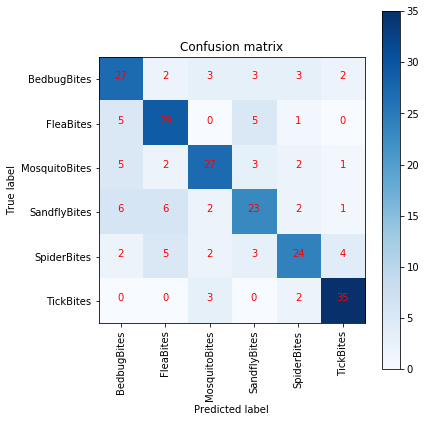

In [67]:
def metrics_confusion_matrix(cmtx, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    fig = plt.figure(figsize=(6,6))
    plt.imshow(cmtx, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cmtx = cmtx.astype('float') / cmtx.sum(axis=1)[:, np.newaxis]
       
    for i, j in itertools.product(range(cmtx.shape[0]), range(cmtx.shape[1])):
        plt.text(j, i, cmtx[i, j],
                 horizontalalignment="center",
                 color="red" )

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# confusion matrix
confusionMatrix = confusion_matrix(true_classes, pred_class_label) 

# plot the confusion matrix
metrics_confusion_matrix(confusionMatrix, classes = class_labels) 

In [68]:
class_labels = list(test_generator.class_indices.keys())   
report = metrics.classification_report(true_classes, pred_class_label, target_names=class_labels)
print(report) 

               precision    recall  f1-score   support

  BedbugBites       0.60      0.68      0.64        40
    FleaBites       0.66      0.72      0.69        40
MosquitoBites       0.73      0.68      0.70        40
 SandflyBites       0.62      0.57      0.60        40
  SpiderBites       0.71      0.60      0.65        40
    TickBites       0.81      0.88      0.84        40

    micro avg       0.69      0.69      0.69       240
    macro avg       0.69      0.69      0.69       240
 weighted avg       0.69      0.69      0.69       240



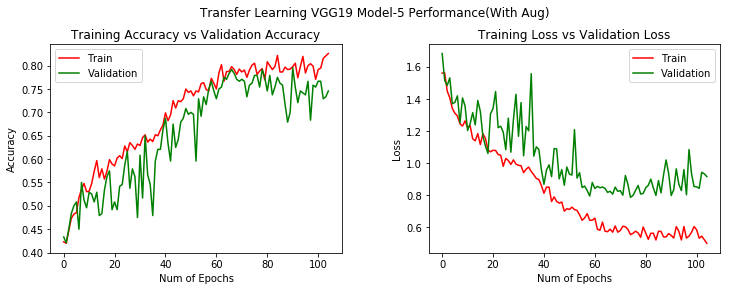

In [69]:
# summarize history for accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = fig.suptitle('Transfer Learning VGG19 Model-5 Performance(With Aug)', fontsize=12)
fig.subplots_adjust(top=0.85, wspace=0.3)

#plt.figure(0)
ax1.plot(Model1_VGG19_WA5.history['acc'],'r')
ax1.plot(Model1_VGG19_WA5.history['val_acc'],'g')
ax1.set_xlabel("Num of Epochs")
ax1.set_ylabel("Accuracy")
ax1.set_title("Training Accuracy vs Validation Accuracy")
ax1.legend(['Train','Validation'])

#ax2.figure(1)
ax2.plot(Model1_VGG19_WA5.history['loss'],'r')
ax2.plot(Model1_VGG19_WA5.history['val_loss'],'g')
ax2.set_xlabel("Num of Epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Training Loss vs Validation Loss")
ax2.legend(['Train','Validation'])